In [1]:
#import packages
import numpy as np
import json 
import scanpy as sc
from collections import OrderedDict
import scipy 
import pandas as pd
import matplotlib.pyplot as plt

#spectra imports 
import Spectra as spc
from Spectra import Spectra_util as spc_tl
from Spectra import K_est as kst
from Spectra import default_gene_sets

### Set up model training

In [3]:
obs_key = 'cell_type_annotations'

In [4]:
adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/snrna_human_tonsil.h5ad')
adata.X = adata.layers['imputed_count']
adata.obs['cell_type'].value_counts()

cell_type
GC B           1581
B memory        873
B naive         715
T cells         593
CD4+ T          530
DC              494
Plasma          490
Tfh             404
Macrophages      98
Name: count, dtype: int64

In [210]:
# adata.obs = adata.obs.join(pd.read_csv('tmp/banksy_celltypes.csv', index_col=0))
adata.obs[obs_key] = adata.obs['cell_type']
adata.obs[obs_key].value_counts()

cell_type_annotations
GC B           1581
B memory        873
B naive         715
T cells         593
CD4+ T          530
DC              494
Plasma          490
Tfh             404
Macrophages      98
Name: count, dtype: int64

In [211]:
tmp_annot = spc.default_gene_sets.load()
tmp_annot.keys()

dict_keys(['B_GC', 'B_memory', 'B_naive', 'CD4_T', 'CD8_T', 'DC', 'ILC3', 'MDC', 'NK', 'Treg', 'gdT', 'mast', 'pDC', 'plasma', 'global'])

In [212]:
relabels = {
    'GC B': 'B_GC',
    'B memory': 'B_memory',
    'B naive': 'B_naive',
    'T cells': 'CD8_T',
    'CD4+ T': 'CD4_T',
    'Plasma': 'plasma',
    'Tfh': 'CD4_T',
    'Macrophages': 'MDC'
}

adata.obs[obs_key] = adata.obs[obs_key].replace(relabels)

annotations = tmp_annot.copy()
for k in tmp_annot.keys():
    if k not in adata.obs[obs_key].unique():
        del annotations[k]

annotations['global'] = tmp_annot['global']

/tmp/ipykernel_36400/1985503755.py:12: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs[obs_key] = adata.obs[obs_key].replace(relabels)


In [213]:
for k, v in annotations.items():
    if k == 'global':
        continue
    annotations[k] = {}

In [214]:
annotations = spc_tl.check_gene_set_dictionary(
    adata,
    annotations,
    obs_key='cell_type_annotations',
    global_key='global'
)

Cell type labels in gene set annotation dictionary and AnnData object are identical
removing gene set all_biotin_metabolism for cell type global which is of length 5 1 genes are found in the data. minimum length is 3
removing gene set all_ethanol_metabolism for cell type global which is of length 12 2 genes are found in the data. minimum length is 3
removing gene set all_carnitine-shuttle for cell type global which is of length 8 2 genes are found in the data. minimum length is 3
removing gene set all_microautophagy-lysosomal for cell type global which is of length 5 0 genes are found in the data. minimum length is 3
removing gene set all_TCA-cycle for cell type global which is of length 21 1 genes are found in the data. minimum length is 3
removing gene set all_lipophagy for cell type global which is of length 7 1 genes are found in the data. minimum length is 3
removing gene set all_pyrimidine_synthesis for cell type global which is of length 7 0 genes are found in the data. minimum 

In [215]:
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=adata.n_vars)

In [216]:
import json
with open('spectra_outs/annotations.json', 'w') as f:
    json.dump(annotations, f)
adata.write_h5ad('spectra_outs/preprocessed.h5ad')

# import json
# with open('spectra_outs/annotations.json', 'r') as f:
#     annotations = json.load(f)
# adata = sc.read_h5ad('spectra_outs/preprocessed.h5ad')


In [ ]:
# fit the model (We will run this with only 2 epochs to decrease runtime in this tutorial)
model = spc.est_spectra(adata=adata, 
    gene_set_dictionary=annotations, 
    use_highly_variable=True,
    cell_type_key="cell_type_annotations", 
    use_weights=True,
    lam=0.1, # varies depending on data and gene sets, try between 0.5 and 0.001
    delta=0.001, 
    kappa=None,
    rho=0.001, 
    use_cell_types=True,
    n_top_vals=50,
    label_factors=True, 
    overlap_threshold=0.2,
    clean_gs = True, 
    min_gs_num = 3,
    num_epochs=10000
)


In [ ]:
adata.write_h5ad('spectra_outs/spectra.h5ad')

#You can save the model like this (this way consumes a lot of storage but does not require the model parameters to load)
import pickle
with open('spectra_outs/model.pickle', 'wb') as f:
    pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

### Examine trained model

In [2]:
# import json
# with open('spectra_outs/annotations.json', 'r') as f:
#     priors = json.load(f)

In [3]:
adata = sc.read_h5ad('spectra_outs/spectra.h5ad')
adata.obs['cell_type_annotations'].value_counts()

cell_type_annotations
B_GC        1581
CD4_T        934
B_memory     873
B_naive      715
CD8_T        593
DC           494
plasma       490
MDC           98
Name: count, dtype: int64

In [4]:
# import pickle
# with open('spectra_outs/model.pickle', 'rb') as f:
#     model = pickle.load(f)


In [5]:
index_labels = adata.uns['SPECTRA_overlap'].index
gene_weights = pd.DataFrame(adata.uns['SPECTRA_factors'], 
                            index= index_labels,
                            columns=adata.var_names)

In [6]:
# gene_weights.to_csv('spectra_outs/gene_weights.csv')

In [7]:
factors = adata.uns['SPECTRA_factors'] # factors x genes matrix that tells you how important each gene is to the resulting factors
markers = adata.uns['SPECTRA_markers'] # factors x n_top_vals list of n_top_vals top markers per factor
cell_scores = adata.obsm['SPECTRA_cell_scores'] # cells x factors matrix of cell scores
vocab = adata.var['spectra_vocab'] # boolean matrix of size # of genes that indicates the set of genes used to fit spectra 

In [53]:
pd.DataFrame(adata.uns['SPECTRA_markers'], index=gene_weights.index).T.to_csv('spectra_outs/factor_genes.csv', index=False)

In [9]:
goi = 'PAX5'
markers = [i for i, genes in enumerate(adata.uns['SPECTRA_markers']) if goi in genes]
markers

[0, 2, 9, 20, 29, 31, 50, 60, 67, 78, 80, 83, 88, 90]

In [93]:
n=1
delta_X=np.load(f'/ix/djishnu/shared/djishnu_kor11/perturbations/snrna_human_tonsil_deltas/{goi}_{n}n_0x.npy')

def get_normalized_scores(counts, goi, gene_weights):
    gene_weights = gene_weights.copy()
    gene_weights[goi] = 0
    factors = gene_weights.values
    return counts @ (factors / np.sum(factors, axis=1).reshape(-1, 1)).T

delta_cell_scores = get_normalized_scores(delta_X, goi=goi, gene_weights=gene_weights)
delta_cell_scores.shape

(5778, 98)

In [94]:
# n=3
# simulated_count = pd.read_parquet(f'/ix/djishnu/shared/djishnu_kor11/perturbations/snrna_human_tonsil/{goi}_3n_0x.parquet')



# cell_scores = get_normalized_scores(adata.layers['imputed_count'], goi, gene_weights)
# sim_cell_scores = get_normalized_scores(simulated_count, goi, gene_weights)

# np.all(adata.obsm['SPECTRA_cell_scores'] == cell_scores)

In [95]:
# def get_delta_scores(cell_scores, sim_cell_scores): 
#     # return (sim_cell_scores - cell_scores)  / np.percentile(cell_scores, 70, axis=0).reshape(1, -1)
#     abs_change = sim_cell_scores - cell_scores
#     return abs_change # / np.abs(cell_scores).mean(axis=0)

# delta_cell_scores = get_delta_scores(cell_scores, sim_cell_scores)

In [96]:
def get_delta_df(delta_cell_scores, adata, gene_weights):
    delta_df = pd.DataFrame(delta_cell_scores, index=adata.obs_names)
    delta_df.columns = [i for i in gene_weights.index]
    delta_df['cell_type'] = adata.obs['cell_type_annotations'].values

    delta_df = delta_df.melt(var_name='Factor', value_name='Delta Cell Score', id_vars='cell_type')
    return delta_df

delta_df = get_delta_df(delta_cell_scores, adata, gene_weights)

In [97]:
delta_df = delta_df[~delta_df['Factor'].str.contains('global')]
delta_df['Factor'] = delta_df['Factor'].astype(str)

In [98]:
import seaborn as sns
results_dir = f'/ix/djishnu/shared/djishnu_kor11/results/tonsil_v3/{goi}'

import os
os.makedirs(results_dir, exist_ok=True)

/ix/djishnu/alw399/envs/spectra/lib/python3.9/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/ix/djishnu/alw399/envs/spectra/lib/python3.9/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


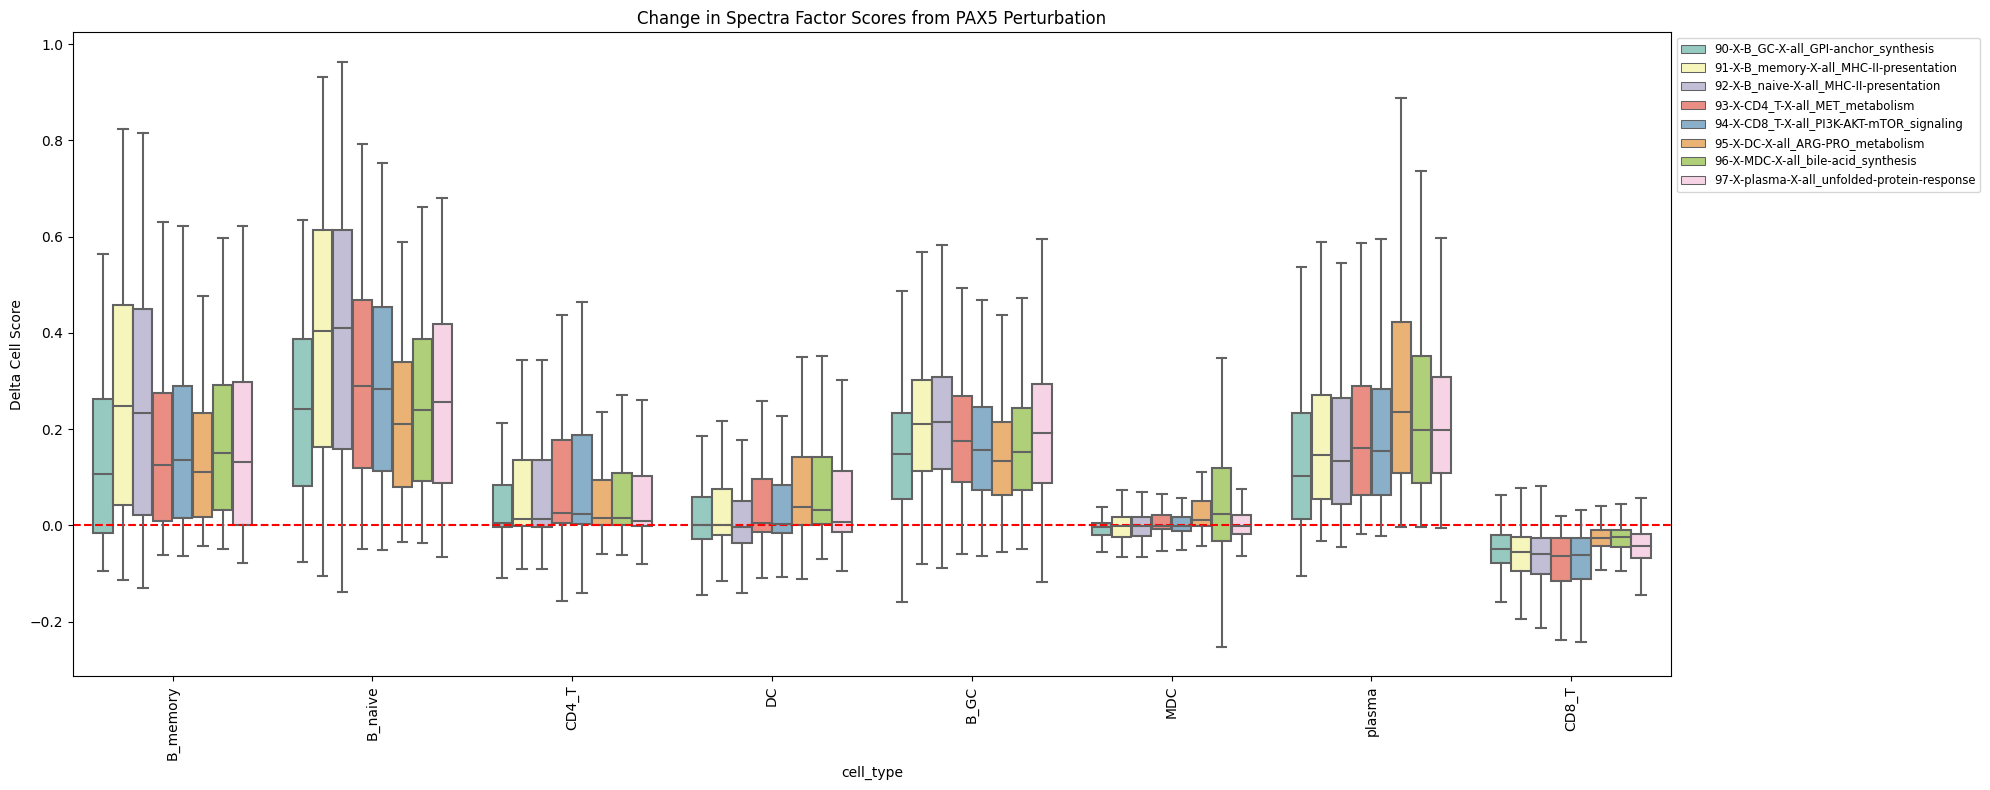

In [99]:
from statannotations.Annotator import Annotator
import itertools 

fig, ax = plt.subplots(figsize=(20, 8), dpi=100)
plt.axhline(0, linestyle='--', color='red')
sns.boxplot(data=delta_df, 
            hue='Factor', 
            x='cell_type',
            y='Delta Cell Score', 
            palette='Set3',  
            showfliers=False
        )

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.title(f'Change in Spectra Factor Scores from {goi} Perturbation')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(f'{results_dir}/delta_cell_scores_{n}.png')
plt.show()

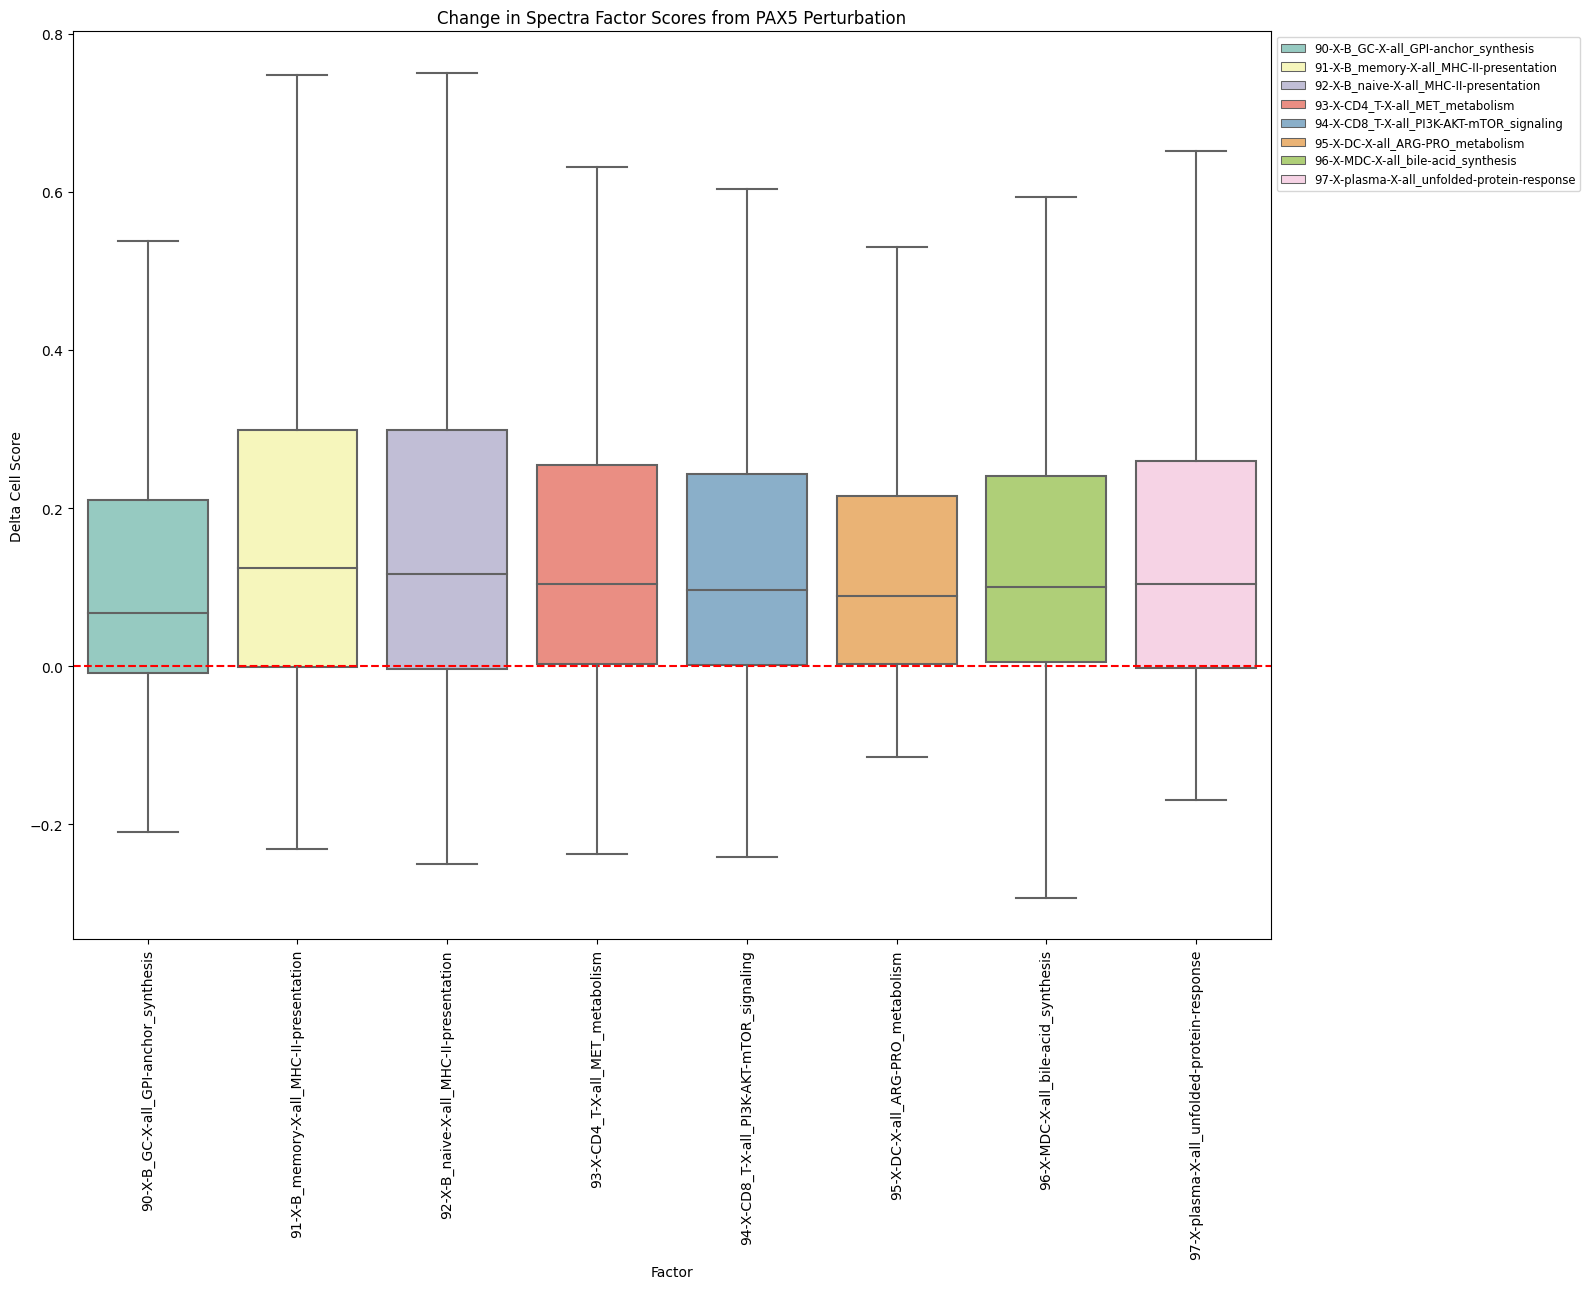

In [100]:
fig, ax = plt.subplots(figsize=(16, 13), dpi=100)
plt.axhline(0, linestyle='--', color='red')
sns.boxplot(data=delta_df, 
            hue='Factor', 
            x='Factor',
            y='Delta Cell Score', 
            palette='Set3',  
            showfliers=False,
            dodge=False
        )

# pairs=list(itertools.combinations(np.unique(delta_df['Factor']), 2))

# annotator = Annotator(ax, pairs, data=delta_df, x='Factor', y='Delta Cell Score', order=np.unique(delta_df['Factor']))
# annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', hide_non_significant=True)
# annotator.apply_and_annotate()

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.title(f'Change in Spectra Factor Scores from {goi} Perturbation')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(f'{results_dir}/delta_cell_scores_grouped_{n}n.png')
plt.show()

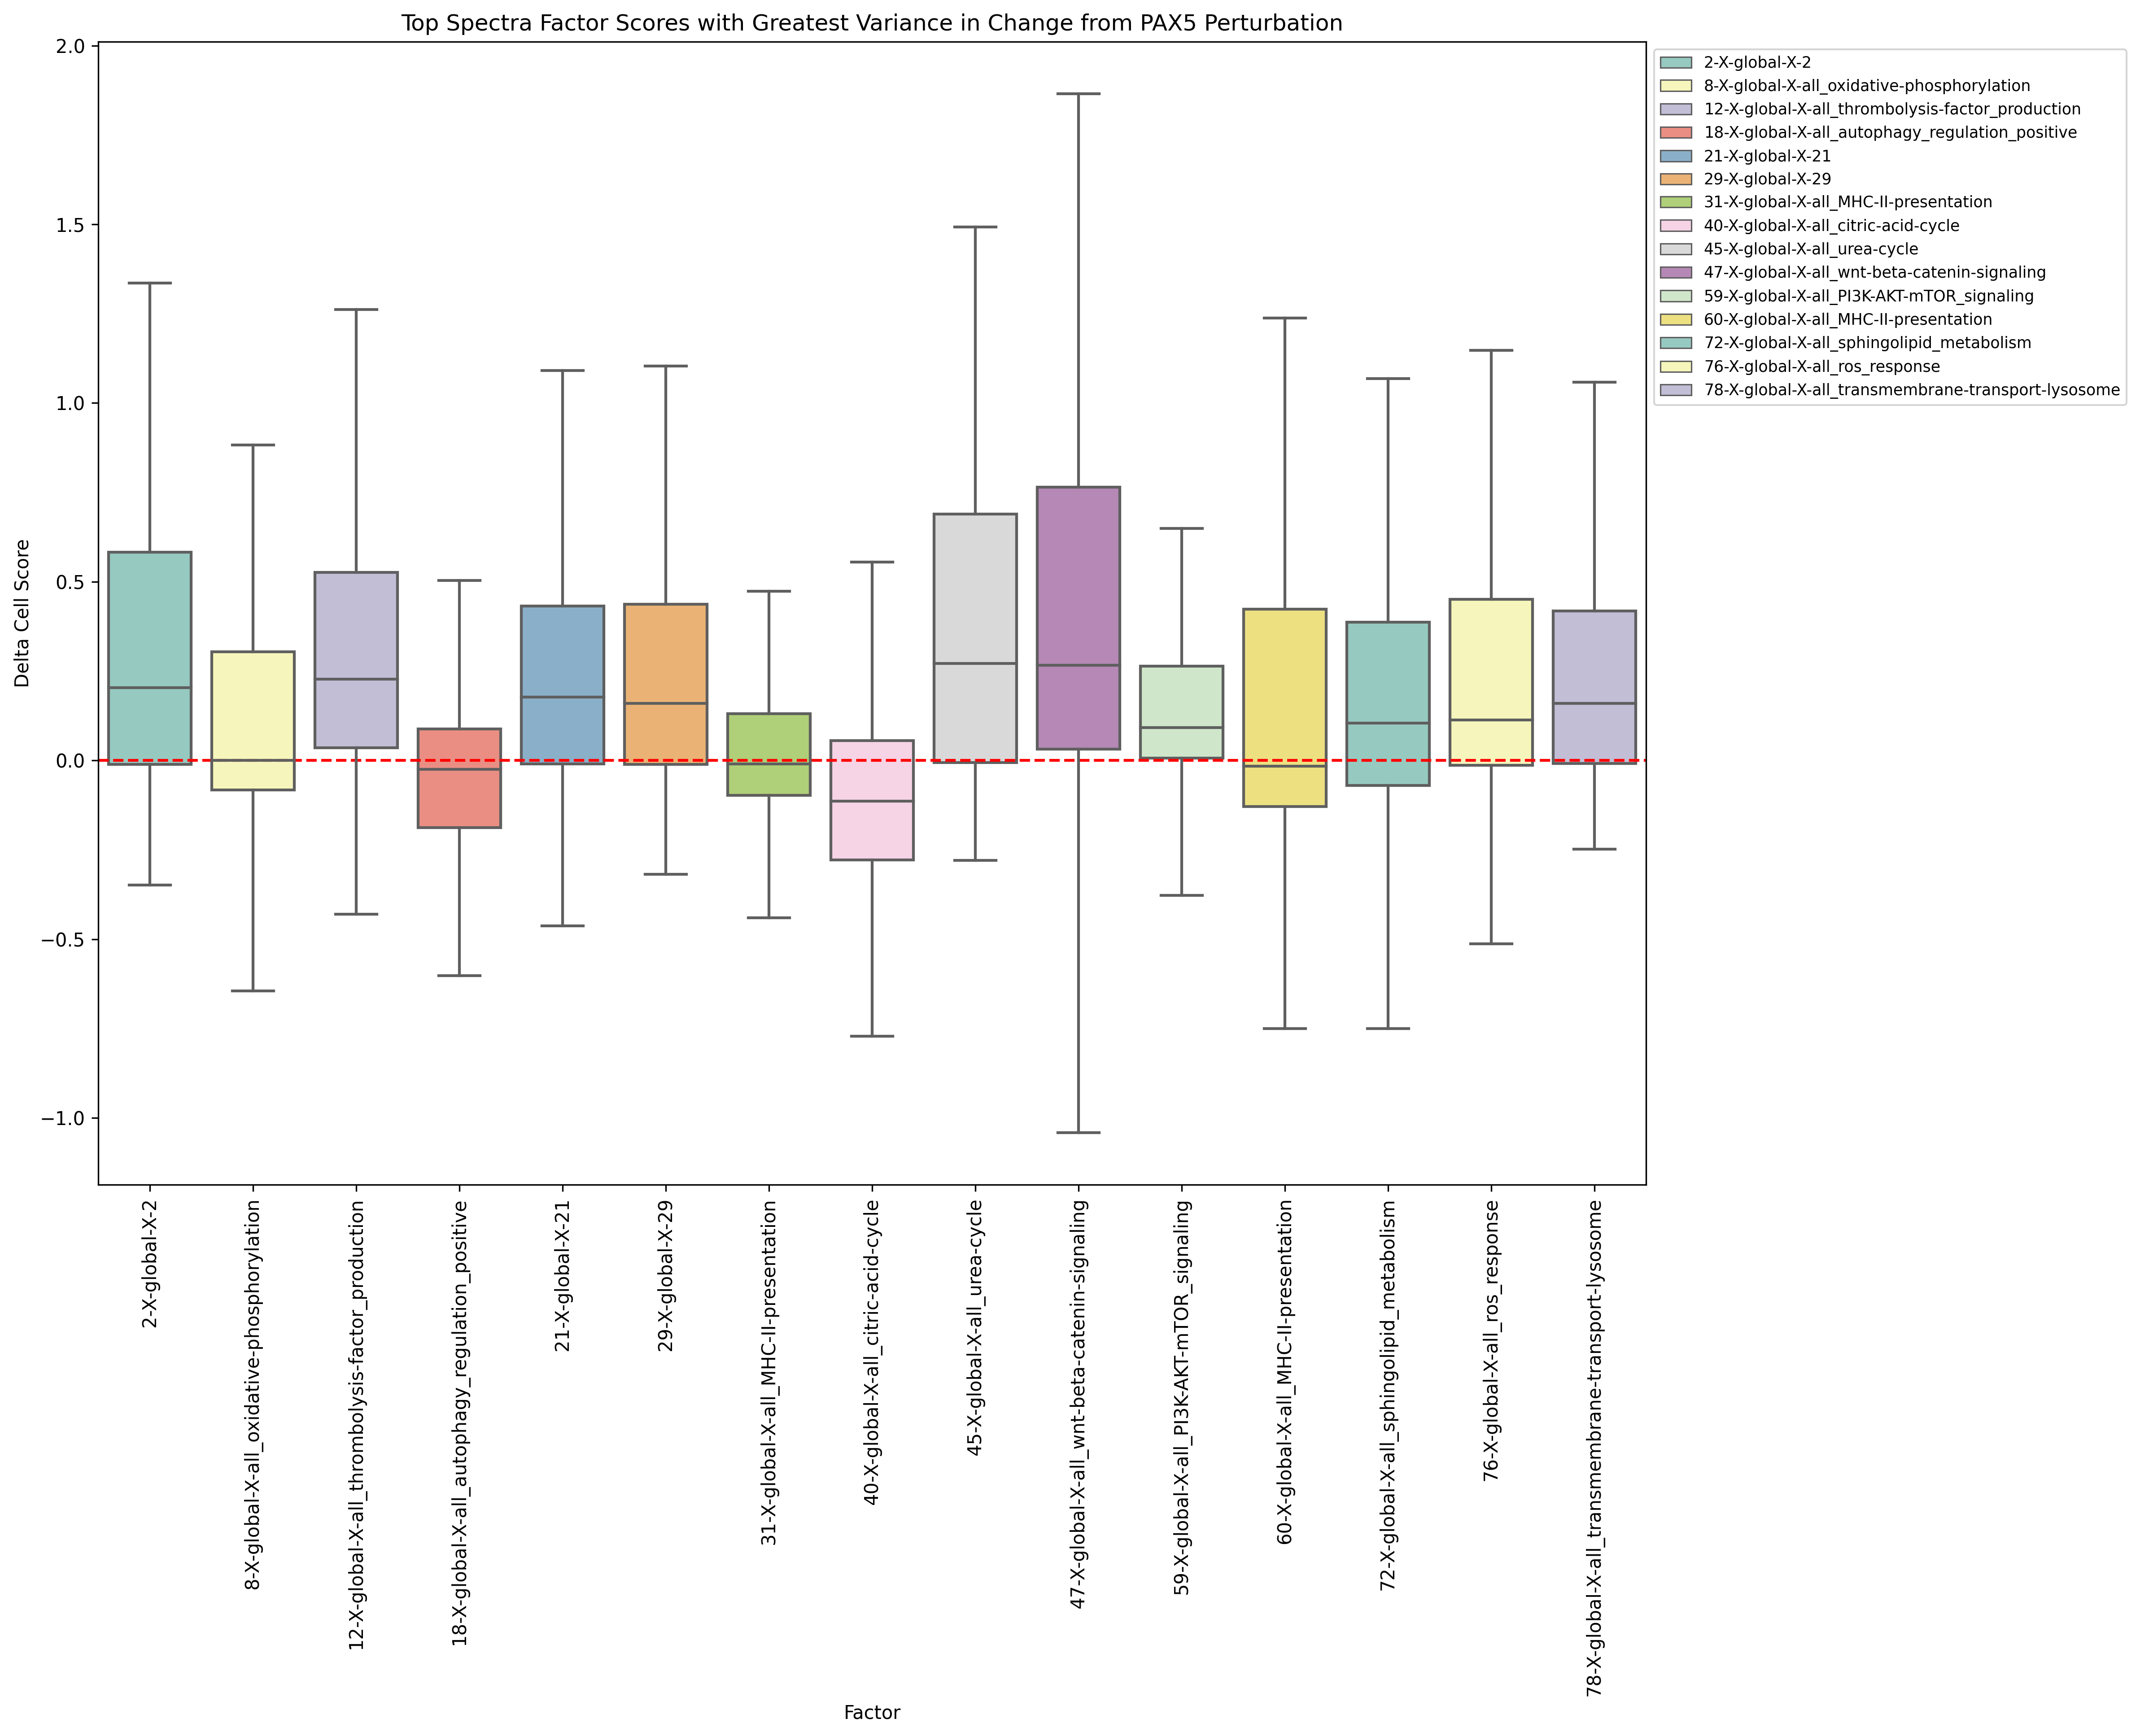

In [101]:
delta_df = get_delta_df(delta_cell_scores, adata, gene_weights)

top_15_factors = delta_df.groupby('Factor')['Delta Cell Score'].var().nlargest(15).index
delta_df = delta_df[delta_df['Factor'].isin(top_15_factors)]

fig, ax = plt.subplots(figsize=(16, 13), dpi=300)
plt.axhline(0, linestyle='--', color='red')
sns.boxplot(data=delta_df, 
            hue='Factor', 
            x='Factor',
            y='Delta Cell Score', 
            palette='Set3',  
            showfliers=False,
            dodge=False
        )

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.title(f'Top Spectra Factor Scores with Greatest Variance in Change from {goi} Perturbation')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(f'{results_dir}/delta_cell_scores_top_{n}n.png')
plt.show()

/ix/djishnu/alw399/envs/spectra/lib/python3.9/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/ix/djishnu/alw399/envs/spectra/lib/python3.9/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


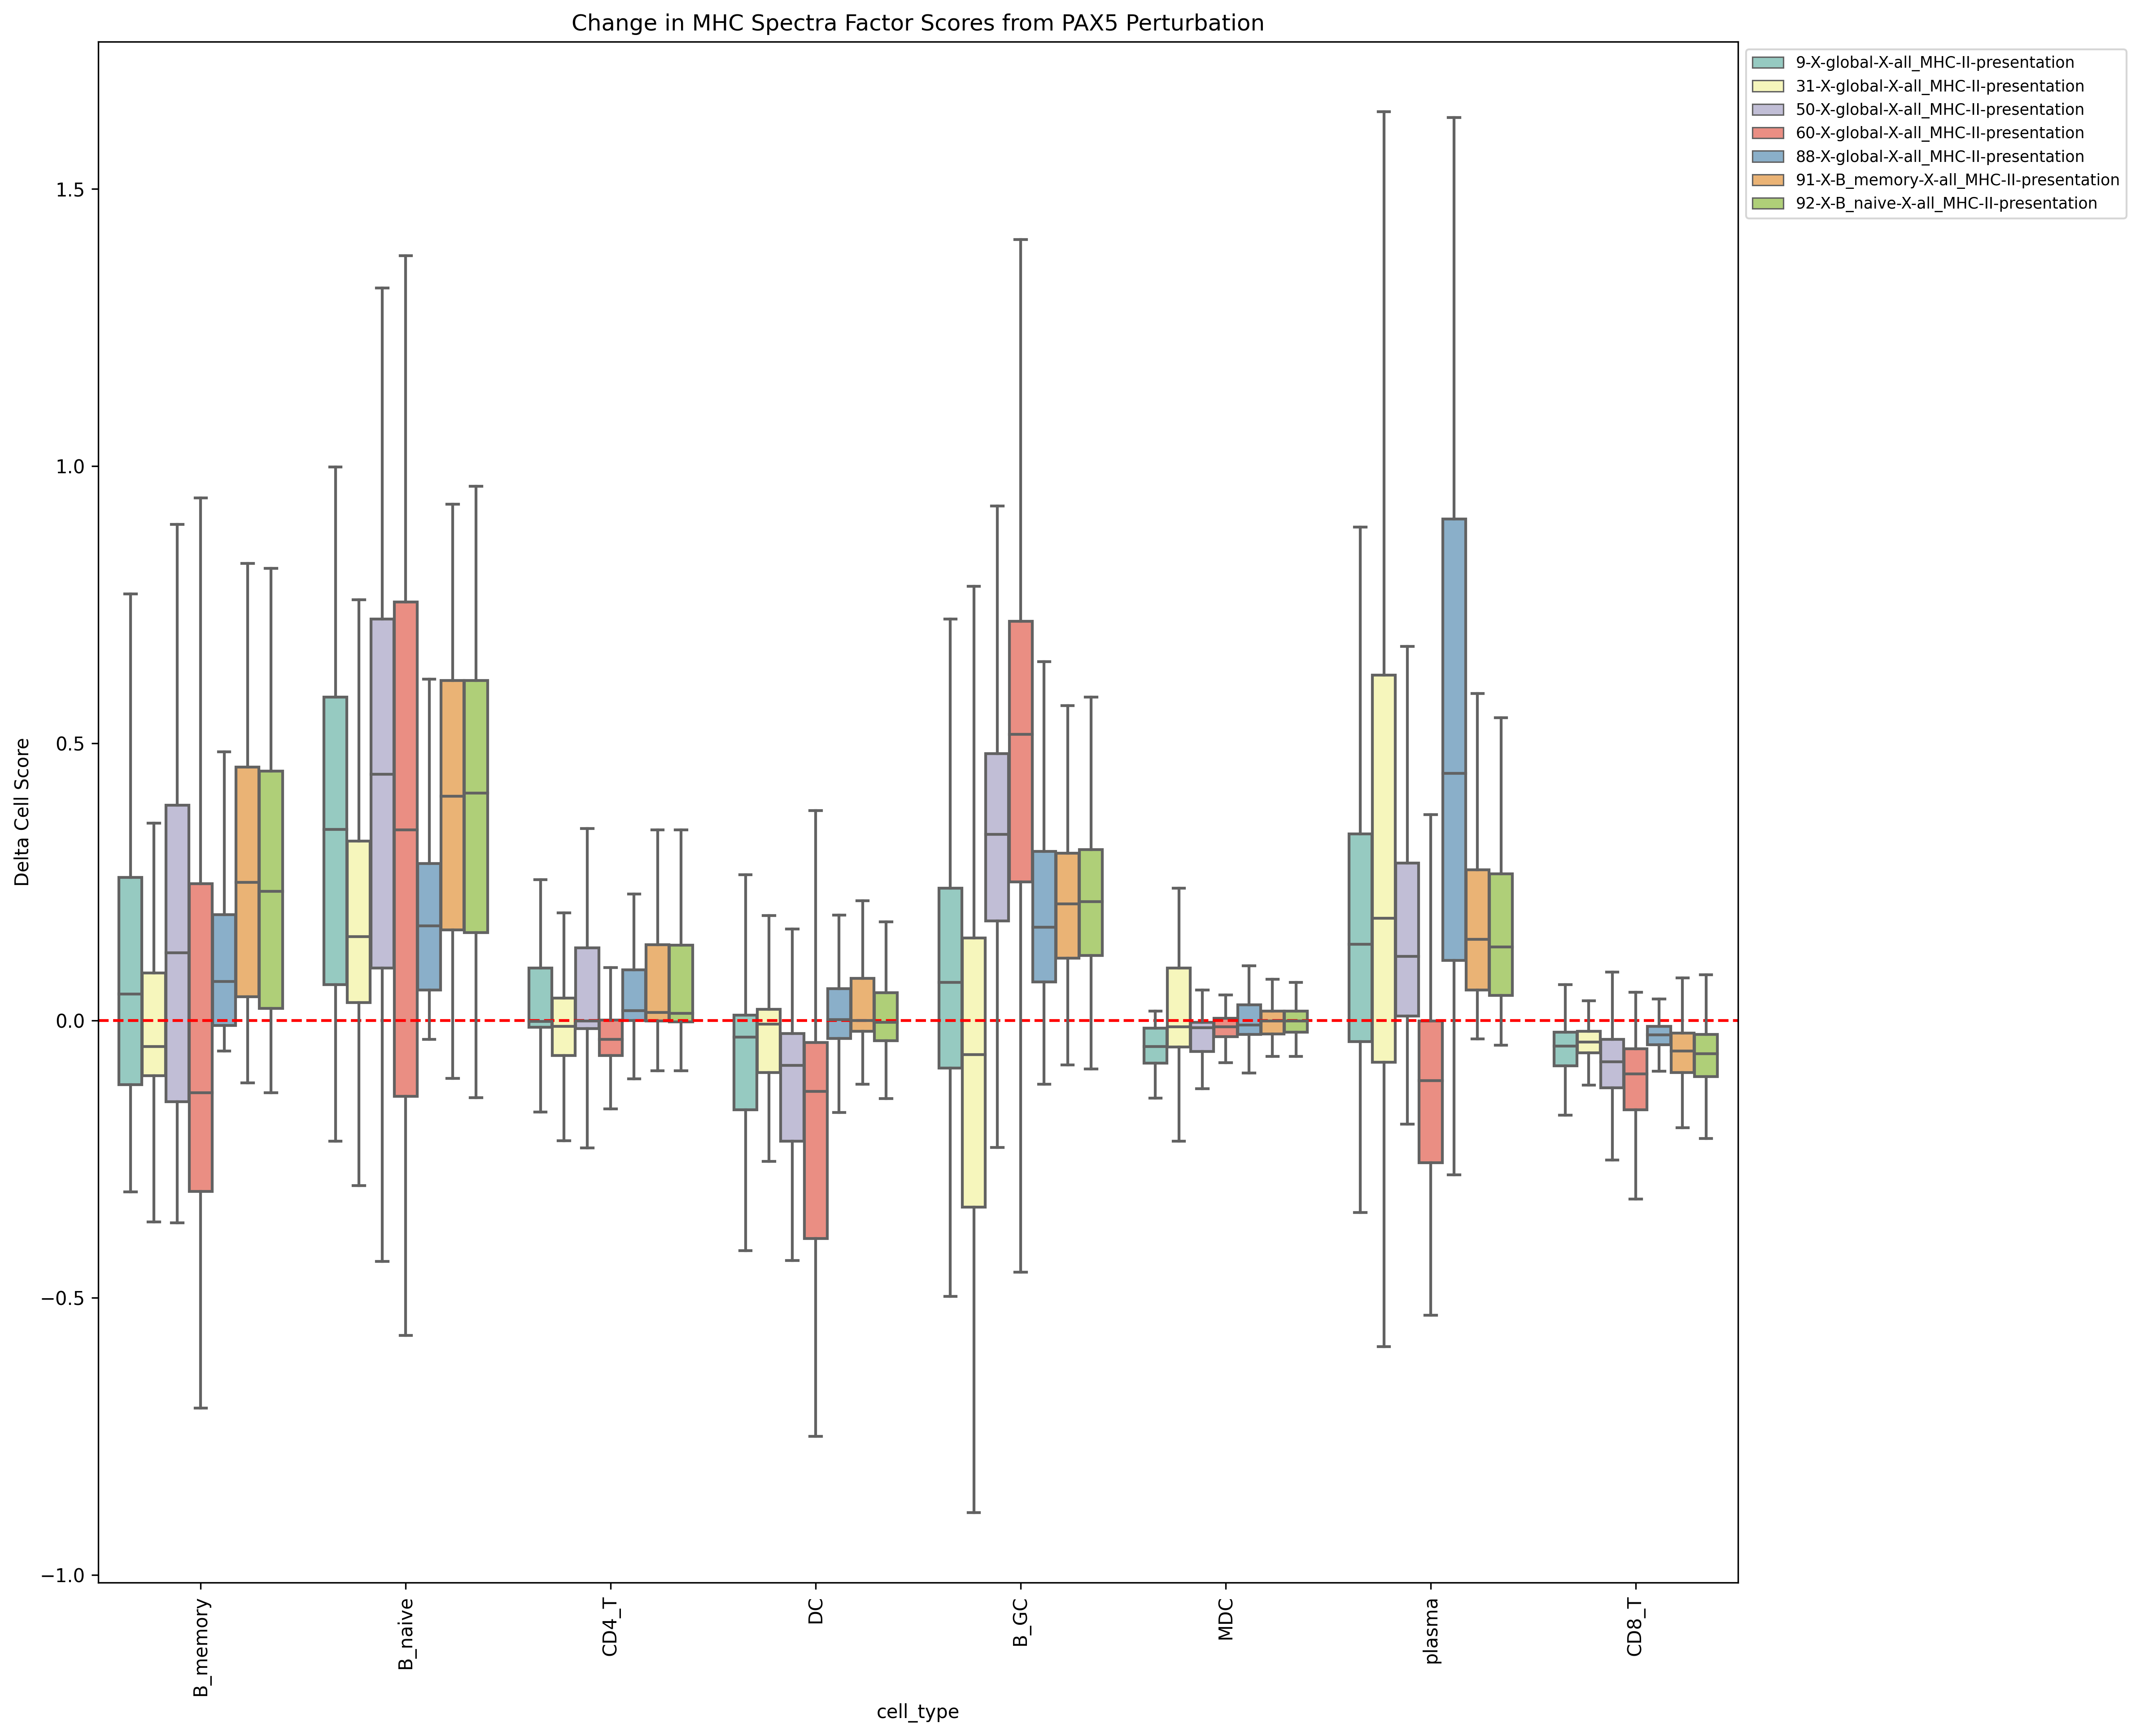

In [102]:
delta_df = get_delta_df(delta_cell_scores, adata, gene_weights)

keyword='MHC'

delta_df = delta_df[delta_df['Factor'].str.contains(keyword)]
delta_df['Factor'] = delta_df['Factor'].astype(str)

fig, ax = plt.subplots(figsize=(16, 13), dpi=300)
plt.axhline(0, linestyle='--', color='red')
sns.boxplot(data=delta_df, 
            hue='Factor', 
            x='cell_type',
            y='Delta Cell Score', 
            palette='Set3',  
            showfliers=False,
            dodge=True
        )

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.title(f'Change in {keyword} Spectra Factor Scores from {goi} Perturbation')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(f'{results_dir}/delta_cell_scores_{keyword}_{n}n.png')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(16, 6), dpi=300)
plt.axhline(0, linestyle='--', color='red')
sns.boxplot(data=delta_df, 
            hue='Factor', 
            x='cell_type',
            y='Delta Cell Score', 
            palette='Set3',  
            showfliers=False)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.title(f'Change in Spectra Factor Scores from {goi} Perturbation')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(f'{results_dir}/delta_cell_scores.png')
plt.show()